In [ ]:
!wget --no-check-certificate \
    https://pjreddie.com/media/files/yolov3.weights \
    -O /content/yolov3.weights

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2
from tensorflow.keras.layers import Conv2D,Activation,BatchNormalization,Dense,LeakyReLU, \
Input,Add,Concatenate
from tensorflow.keras.models import Model

In [ ]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (608,608)
currC = 0
currB = 0
C = "conv"
B = "batch"

In [ ]:
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names
class_names = load_class_names('datasets_81753_300187_coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

In [ ]:
def padd(x,kernel):
    pad_total = kernel - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    return tf.pad(x,[[0,0],[pad_beg,pad_end],[pad_beg,pad_end],[0,0]])

def Conv2DFixedPadding(x,filters,kernel,strides,name,use_bias):
    padding = 'same'
    if(strides > 1):
        x = padd(x,kernel)
        padding = 'valid'
    return Conv2D(filters,kernel,strides,padding,name=name,use_bias=use_bias)(x)

In [ ]:
def darknet53ResidualBlock(x,filters,training,strides=1):
    global currB,currC,B,C
    skip = x
    x = Conv2DFixedPadding(x,filters,1,strides,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,2*filters,3,strides,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x += skip
    return x

def darkNet53(x,training):
    global currB,currC,B,C
    x = Conv2DFixedPadding(x,32,3,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,64,3,2,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = darknet53ResidualBlock(x,32,training)
    x = Conv2DFixedPadding(x,128,3,2,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    for _ in range(2):
        x = darknet53ResidualBlock(x,64,training)
    x = Conv2DFixedPadding(x,256,3,2,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    for _ in range(8):
        x = darknet53ResidualBlock(x,128,training)
    route1 = x
    x = Conv2DFixedPadding(x,512,3,2,name=C+str(currC),use_bias=False )
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    for _ in range(8):
        x = darknet53ResidualBlock(x,256,training)
    route2 = x
    x = Conv2DFixedPadding(x,1024,3,2,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    for _ in range(4):
        x = darknet53ResidualBlock(x,512,training)
    return route1,route2,x

def yoloCBlock(x,filters,training):
    global currB,currC,B,C
    x = Conv2DFixedPadding(x,filters,1,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,2*filters,3,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,filters,1,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,2*filters,3,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    x = Conv2DFixedPadding(x,filters,1,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)
    route = x
    x = Conv2DFixedPadding(x,2*filters,3,1,name=C+str(currC),use_bias=False)
    currC += 1
    x = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(x)
    currB += 1
    x = LeakyReLU(alpha=_LEAKY_RELU)(x)

    return route,x

class yoloLayer(tf.keras.layers.Layer):
    
    def get_config(self):

        config = {
            'n_classes' : self.n_classes,
            'anchors' : self.anchors,
            'img_size' : self.img_size
        }
        base_config = super(yoloLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def __init__(self,n_classes,anchors,img_size,**kwargs):
        super(yoloLayer,self).__init__(**kwargs)
        self.n_classes = n_classes
        self.anchors = anchors
        self.img_size = img_size

    def call(self,inputs):
        n_anchors = len(self.anchors)
        shape = inputs.get_shape().as_list()
        grid_shape = shape[1:3]
        inputs = tf.reshape(inputs,[-1,n_anchors*grid_shape[0]*grid_shape[1],5+self.n_classes])
        strides = (self.img_size[0]//grid_shape[0],self.img_size[1]//grid_shape[1])
        box_centers,box_shapes,confidence,classes = tf.split(inputs,[2,2,1,self.n_classes],axis=-1)
        x = tf.range(grid_shape[0],dtype=tf.float32)
        y = tf.range(grid_shape[1],dtype=tf.float32)
        x_offset,y_offset = tf.meshgrid(x,y)
        x_offset = tf.reshape(x_offset,(-1,1))
        y_offset = tf.reshape(y_offset,(-1,1))
        x_y_offset = tf.concat([x_offset,y_offset],axis=-1)
        x_y_offset = tf.tile(x_y_offset,[1,n_anchors])
        x_y_offset = tf.reshape(x_y_offset,[1,-1,2])
        box_centers = tf.keras.activations.sigmoid(box_centers)
        box_centers = (box_centers+x_y_offset)*strides

        anchors = tf.tile(self.anchors,[grid_shape[0]*grid_shape[1],1])
        box_shapes = tf.exp(box_shapes) * tf.cast(anchors,dtype=tf.float32)
        confidence = tf.keras.activations.sigmoid(confidence)
        classes = tf.keras.activations.sigmoid(classes)
        return tf.concat([box_centers,box_shapes,confidence,classes],axis=-1)


class upsample(tf.keras.layers.Layer):

    def get_config(self):

        config = {
          'out_shape': self.out_shape
        }
        base_config = super(upsample, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def __init__(self,out_shape,**kwargs):
        super(upsample,self).__init__(**kwargs)
        self.out_shape = out_shape

    def call(self,input):
        new_height = self.out_shape[2]
        new_width = self.out_shape[1]
        input = tf.image.resize(input,(new_width,new_height),method='nearest')
        return input



In [ ]:
def yolov3(n_classes,model_size,max_output_size,iou_threshold
           , confidence_threshold,training):
    global currB,currC,B,C
    currB = 0
    currC = 0
    inputLayer = Input(_MODEL_SIZE+(3,),name="input")
    r1,r2,x = darkNet53(inputLayer,False)
    route ,x = yoloCBlock(x,512,training)
    x = Conv2DFixedPadding(x,3*(5+n_classes),1,1,use_bias=True,name=C+str(currC))
    currC += 1
    detect1 = yoloLayer(n_classes,_ANCHORS[6:9],model_size)(x)
    route = Conv2DFixedPadding(route,256,1,1,name=C+str(currC),use_bias=False)
    currC += 1
    route = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(route)
    currB += 1
    route = LeakyReLU(_LEAKY_RELU)(route)
    upsampleSize = r2.get_shape().as_list()
    route = upsample(upsampleSize)(route)
    x = Concatenate(axis=3)([route,r2])
    route, x = yoloCBlock(x,256,training)
    x = Conv2DFixedPadding(x,3*(5+n_classes),1,1,use_bias=True,name=C+str(currC))
    currC += 1
    detect2 = yoloLayer(n_classes,_ANCHORS[3:6],model_size)(x)
    route = Conv2DFixedPadding(route,128,1,1,name=C+str(currC),use_bias=False)
    currC += 1
    route = BatchNormalization(3,_BATCH_NORM_DECAY,_BATCH_NORM_EPSILON,trainable=training,name=B+str(currB))(route)
    currB += 1
    route = LeakyReLU(_LEAKY_RELU)(route)
    upsampleSize = r1.get_shape().as_list()
    route = upsample(upsampleSize)(route)
    x = Concatenate(axis=3)([route,r1])
    route, x = yoloCBlock(x,128,training)
    x = Conv2DFixedPadding(x,3*(5+n_classes),1,1,use_bias=True,name=C+str(currC))
    currC += 1
    detect3 = yoloLayer(n_classes,_ANCHORS[3:6],model_size)(x)
    x = Concatenate(axis=1)([detect1,detect2,detect3])

    model = Model(inputLayer,x)
    model.summary()
    return model


In [ ]:
model = yolov3(n_classes,_MODEL_SIZE,max_output_size,iou_threshold,confidence_threshold,False)

In [ ]:
def get_weights(filename):
    with open(filename,"rb") as f:
        np.fromfile(f,dtype=np.int32,count=5)
        weights = np.fromfile(f,dtype=np.float32)
        conv_weights = []
        batch_weights = []
        ptr = 0
        dec = 0
        for i in range(75):
            clayer = model.get_layer("conv"+str(i))
            cweights = clayer.get_weights()
            if(len(cweights) == 1):
                blayer = model.get_layer("batch"+str(i-dec))
                bweights = blayer.get_weights()
                bweights = [bweights[1],bweights[0],bweights[2],bweights[3]]
                new_bweights = []
                for var in bweights:
                    shape = list(var.shape)
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    new_bweights.append(var_weights)
                new_bweights = [new_bweights[1],new_bweights[0],new_bweights[2],new_bweights[3]]
                blayer.set_weights(new_bweights)
                shape = list(cweights[0].shape)
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape((shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                clayer.set_weights([var_weights])
            else:
                dec += 1
                bias = cweights[1]
                shape = list(bias.shape)
                num_params = np.prod(shape)
                new_bias = weights[ptr:ptr+num_params].reshape(shape)
                ptr += num_params
                shape = list(cweights[0].shape)
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape((shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                clayer.set_weights([var_weights,new_bias])


In [ ]:
get_weights('yolov3.weights')

In [ ]:
def build_boxes(inputs):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes

def nonMaxSuppression(result,n_classes,max_output_size,iou_threshold,confidence_threshold):
    batch = tf.unstack(result)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes,boxes[:,4]>confidence_threshold)
        classes = tf.argmax(boxes[:,5:],axis=-1)
        classes = tf.expand_dims(tf.cast(classes,tf.float32),axis=-1)
        boxes = tf.concat([boxes[:,:5],classes],axis=-1)
        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:,5],cls)
            mask_shape = mask.get_shape()
            if(mask_shape.ndims != 0):
                class_boxes = tf.boolean_mask(boxes,mask)
                boxes_coords,boxes_conf_scores,_ = tf.split(class_boxes,[4,1,-1],axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(
                    boxes_coords,
                    boxes_conf_scores,
                    max_output_size,
                    iou_threshold
                )
                class_boxes = tf.gather(class_boxes,indices)
                boxes_dict[cls] = class_boxes[:,:5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts





In [ ]:
def load_images(img_names, model_size):
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size,save_dir = None):
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='datasets_81753_300187_futur.ttf',
                                  size=(img.size[0] + img.size[1]) // 150)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 250
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    print(class_names[cls])
                    text = '{} {:.1f}%'.format(class_names[cls],
                                               confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle(
                        [x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)

        display(img)
        if(save_dir != None):
            img.save(save_dir)

person
car
car
car
car
car
car
car
traffic light


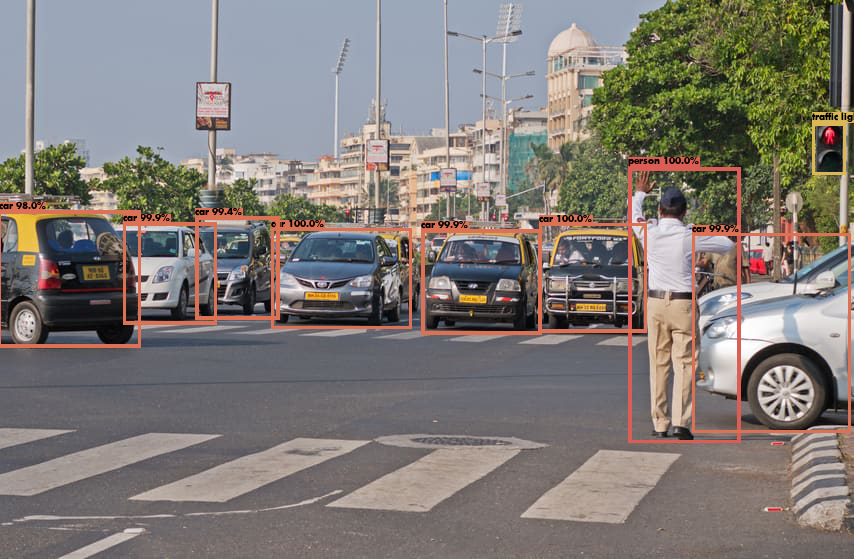

In [18]:
img_names = ['yolov3 test images/test04.jpg']
inp = load_images(img_names,_MODEL_SIZE)
inp = inp/255.0
res = model.predict(inp)
res = build_boxes(res)
res = nonMaxSuppression(res,n_classes,max_output_size,iou_threshold,confidence_threshold)
draw_boxes(img_names,res,class_names,_MODEL_SIZE,save_dir='yolov3 test images/results/test04.jpg')

In [ ]:
model.save('saved models/yolo.h5')

In [ ]:
test = tf.keras.models.load_model()